# Huggingface Sagemaker-sdk - Getting Started Demo
### Binary Classification with `Trainer` and `imdb` dataset

1. [Introduction](#Introduction)  
2. [Development Environment and Permissions](#Development-Environment-and-Permissions)
    1. [Installation](#Installation)  
    2. [Development environment](#Development-environment)  
    3. [Permissions](#Permissions)
3. [Processing](#Preprocessing)   
    1. [Tokenization](#Tokenization)  
    2. [Uploading data to sagemaker_session_bucket](#Uploading-data-to-sagemaker_session_bucket)  
4. [Fine-tuning & starting Sagemaker Training Job](#Fine-tuning-\&-starting-Sagemaker-Training-Job)  
    1. [Creating an Estimator and start a training job](#Creating-an-Estimator-and-start-a-training-job)  
    2. [Estimator Parameters](#Estimator-Parameters)   
    3. [Download fine-tuned model from s3](#Download-fine-tuned-model-from-s3)
    3. [Attach to old training job to an estimator ](#Attach-to-old-training-job-to-an-estimator)  
5. [_Coming soon_:Push model to the Hugging Face hub](#Push-model-to-the-Hugging-Face-hub)

# Introduction

Welcome to our end-to-end binary Text-Classification example. In this demo, we will use the Hugging Faces `transformers` and `datasets` library together with a custom Amazon sagemaker-sdk extension to fine-tune a pre-trained transformer on binary text classification. In particular, the pre-trained model will be fine-tuned using the `imdb` dataset. To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on. 

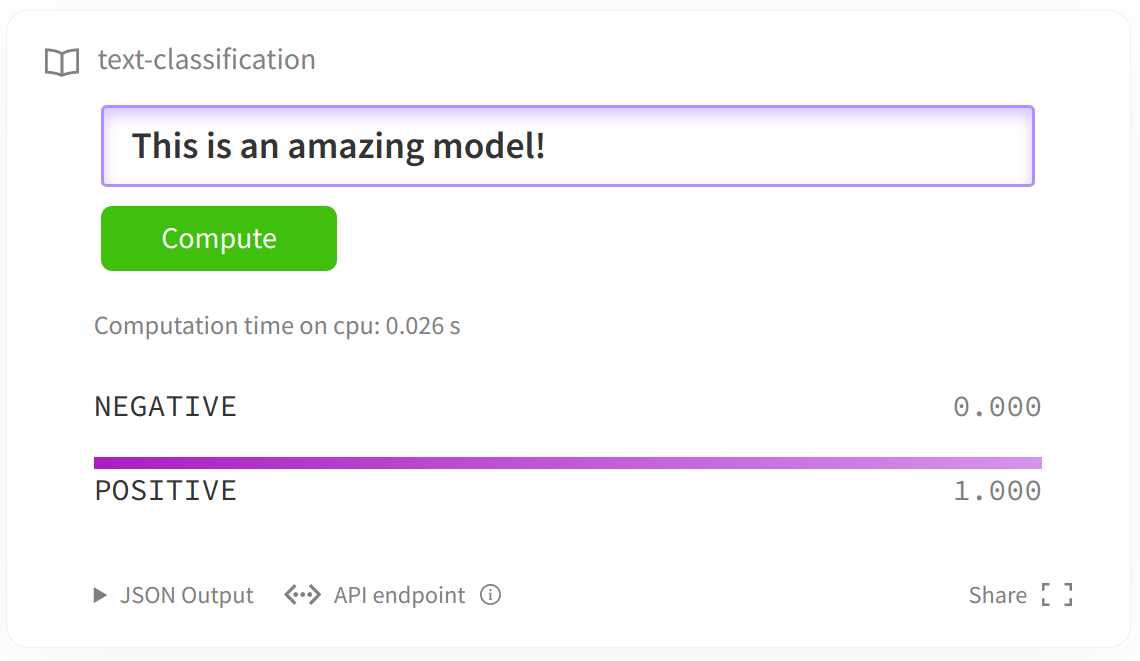

_**NOTE: You can run this demo in Sagemaker Studio, your local machine or Sagemaker Notebook Instances**_

# Development Environment and Permissions 

## Installation

_*Note:* we only install the required libraries from Hugging Face and AWS. You also need PyTorch or Tensorflow, if you haven´t it installed_

In [1]:
!pip install "transformers==4.6.1" "datasets[s3]==1.6.2" --upgrade

     |████████████████████████████████| 2.2 MB 17.8 MB/s eta 0:00:01
     |████████████████████████████████| 221 kB 52.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 50.9 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 56.0 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 74.8 MB/s eta 0:00:01
     |████████████████████████████████| 7.2 MB 54.6 MB/s eta 0:00:01
     |████████████████████████████████| 130 kB 80.0 MB/s eta 0:00:01
     |████████████████████████████████| 73 kB 2.9 MB/s  eta 0:00:01
     |████████████████████████████████| 48 kB 9.0 MB/s  eta 0:00:01
     |████████████████████████████████| 48 kB 1.2 MB/s  eta 0:00:01
  Created wheel for aiobotocore: filename=aiobotocore-1.2.2-py3-none-any.whl size=45730 sha256=a8c8c3d419087736079bcf3a5358a4c96519237ad36d082bffae2b313c7b6403
  Stored in directory: /home/ec2-user/.cache/pip/wheels/37/f3/76/dfc2d32494696a7e4710

  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.57.0
    Uninstalling tqdm-4.57.0:
      Successfully uninstalled tqdm-4.57.0
  Attempting uninstall: botocore
    Found existing installation: botocore 1.20.99
    Uninstalling botocore-1.20.99:
      Successfully uninstalled botocore-1.20.99
  Attempting uninstall: s3transfer
    Found existing installation: s3transfer 0.4.2
    Uninstalling s3transfer-0.4.2:
      Successfully uninstalled s3transfer-0.4.2
  Attempting uninstall: aiobotocore
    Found existing installation: aiobotocore 1.3.0
    Uninstalling aiobotocore-1.3.0:
      Successfully uninstalled aiobotocore-1.3.0
  Attempting uninstall: boto3
    Found existing installation: boto3 1.17.99
    Uninstalling boto3-1.17.99:
      Successfully uninstalled boto3-1.17.99
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.61 requ

In [2]:
pip install git+https://github.com/ahsan-z-khan/sagemaker-python-sdk.git@hf-model-inference

  Cloning https://github.com/ahsan-z-khan/sagemaker-python-sdk.git (to revision hf-model-inference) to /tmp/pip-req-build-0qqhsy_s
  Running command git clone -q https://github.com/ahsan-z-khan/sagemaker-python-sdk.git /tmp/pip-req-build-0qqhsy_s
  Running command git checkout -b hf-model-inference --track origin/hf-model-inference
  Switched to a new branch 'hf-model-inference'
  Branch 'hf-model-inference' set up to track remote branch 'hf-model-inference' from 'origin'.
  Created wheel for sagemaker: filename=sagemaker-2.47.3.dev0-py2.py3-none-any.whl size=590586 sha256=d3117da1b16f1f1429cf4cba29abea6401b1e354944f4f50fdbf154e4fb8aec4
  Stored in directory: /tmp/pip-ephem-wheel-cache-qa3x6z49/wheels/78/06/69/060e4a09fe5284c5c09165df3d491b8f68f13a3cda8d13be9d
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.45.0
    Uninstalling sagemaker-2.45.0:
      Successfully uninstalled sagemaker-2.45.0
You should consider upgrading via

## Development environment 

**upgrade ipywidgets for `datasets` library and restart kernel, only needed when prerpocessing is done in the notebook**

In [2]:
%%capture
import IPython
!conda install -c conda-forge ipywidgets -y
IPython.Application.instance().kernel.do_shutdown(True) # has to restart kernel so changes are used

In [1]:
import sagemaker.huggingface

## Permissions

_If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it._

In [2]:
import sagemaker

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::558105141721:role/sagemaker_execution_role
sagemaker bucket: sagemaker-us-east-1-558105141721
sagemaker session region: us-east-1


# Preprocessing

We are using the `datasets` library to download and preprocess the `imdb` dataset. After preprocessing, the dataset will be uploaded to our `sagemaker_session_bucket` to be used within our training job. The [imdb](http://ai.stanford.edu/~amaas/data/sentiment/) dataset consists of 25000 training and 25000 testing highly polar movie reviews.

## Tokenization 

In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer

# tokenizer used in preprocessing
tokenizer_name = 'distilbert-base-uncased'

# dataset used
dataset_name = 'imdb'

# s3 key prefix for the data
s3_prefix = 'samples/datasets/imdb'

In [4]:
# load dataset
dataset = load_dataset(dataset_name)

# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# tokenizer helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

# load dataset
train_dataset, test_dataset = load_dataset('imdb', split=['train', 'test'])
test_dataset = test_dataset.shuffle().select(range(10000)) # smaller the size for test dataset to 10k 


# tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# set format for pytorch
train_dataset =  train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Dataset imdb downloaded and prepared to /home/ec2-user/.cache/huggingface/datasets/imdb/plain_text/1.0.0/4ea52f2e58a08dbc12c2bd52d0d92b30b88c00230b4522801b3636782f625c5b. Subsequent calls will reuse this data.


Reusing dataset imdb (/home/ec2-user/.cache/huggingface/datasets/imdb/plain_text/1.0.0/4ea52f2e58a08dbc12c2bd52d0d92b30b88c00230b4522801b3636782f625c5b)


## Uploading data to `sagemaker_session_bucket`

After we processed the `datasets` we are going to use the new `FileSystem` [integration](https://huggingface.co/docs/datasets/filesystems.html) to upload our dataset to S3.

In [5]:
import botocore
from datasets.filesystems import S3FileSystem

s3 = S3FileSystem()  

# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path,fs=s3)

# save test_dataset to s3
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path,fs=s3)


# Fine-tuning & starting Sagemaker Training Job

In order to create a sagemaker training job we need an `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. In a Estimator we define, which fine-tuning script should be used as `entry_point`, which `instance_type` should be used, which `hyperparameters` are passed in .....



```python
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            base_job_name='huggingface-sdk-extension',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            transformers_version='4.4',
                            pytorch_version='1.6',
                            py_version='py36',
                            role=role,
                            hyperparameters = {'epochs': 1,
                                               'train_batch_size': 32,
                                               'model_name':'distilbert-base-uncased'
                                                })
```

When we create a SageMaker training job, SageMaker takes care of starting and managing all the required ec2 instances for us with the `huggingface` container, uploads the provided fine-tuning script `train.py` and downloads the data from our `sagemaker_session_bucket` into the container at `/opt/ml/input/data`. Then, it starts the training job by running. 

```python
/opt/conda/bin/python train.py --epochs 1 --model_name distilbert-base-uncased --train_batch_size 32
```

The `hyperparameters` you define in the `HuggingFace` estimator are passed in as named arguments. 

Sagemaker is providing useful properties about the training environment through various environment variables, including the following:

* `SM_MODEL_DIR`: A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.

* `SM_CHANNEL_XXXX:` A string that represents the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the HuggingFace estimator’s fit call, named `train` and `test`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_TEST` are set.


To run your training job locally you can define `instance_type='local'` or `instance_type='local-gpu'` for gpu usage. _Note: this does not working within SageMaker Studio_


In [6]:
!pygmentize ./scripts/train.py

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_from_disk
import random
import logging
import sys
import argparse
import os
import torch

if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train-batch-size", type=int, default=32)
    parser.add_argument("--eval-batch-size", type=int, default=64)
    parser.add_argument("--warmup_steps", type=int, default=500)
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--learning_rate", type=str, default=5e-5)

    # Data, model, and output directories
    parser.add_argument("--output-data-dir", type=str, default=os.environ["SM_OUTPUT_DATA_DIR"])
    parser.add_argument("--mod

## Creating an Estimator and start a training job

In [7]:
from sagemaker.huggingface import HuggingFace

# hyperparameters, which are passed into the training job
hyperparameters={'epochs': 1,
                 'train_batch_size': 32,
                 'model_name':'distilbert-base-uncased'
                 }

In [8]:
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            instance_type='ml.p3.2xlarge',
                            instance_count=1,
                            role=role,
                            transformers_version='4.6',
                            pytorch_version='1.7',
                            py_version='py36',
                            hyperparameters = hyperparameters)

In [9]:
# starting the train job with our uploaded datasets as input
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path})

framework huggingface | region us-east-1 | version 4.6 | py_version py36 | instance_type ml.p3.2xlarge | image_scope training | container_version cu110-ubuntu18.04 | distribution {}
huggingface-pytorch-training:1.7-transformers4.6-gpu-py36-cu110-ubuntu18.04
framework debugger | region us-east-1 | version latest | py_version None | instance_type None | image_scope None | container_version None | distribution None
sagemaker-debugger-rules:latest
framework huggingface | region us-east-1 | version 4.6 | py_version py36 | instance_type ml.p3.2xlarge | image_scope training | container_version cu110-ubuntu18.04 | distribution {}
huggingface-pytorch-training:1.7-transformers4.6-gpu-py36-cu110-ubuntu18.04
2021-07-06 13:08:29 Starting - Starting the training job...
2021-07-06 13:08:30 Starting - Launching requested ML instancesProfilerReport-1625576908: InProgress
......
2021-07-06 13:09:46 Starting - Preparing the instances for training.........
2021-07-06 13:11:28 Downloading - Downloading inp

[2021-07-06 13:15:01.416 algo-1:25 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-07-06 13:15:01.587 algo-1:25 INFO profiler_config_parser.py:102] User has disabled profiler.
[2021-07-06 13:15:01.588 algo-1:25 INFO json_config.py:91] Creating hook from json_config at /opt/ml/input/config/debughookconfig.json.
[2021-07-06 13:15:01.589 algo-1:25 INFO hook.py:201] tensorboard_dir has not been set for the hook. SMDebug will not be exporting tensorboard summaries.
[2021-07-06 13:15:01.590 algo-1:25 INFO hook.py:255] Saving to /opt/ml/output/tensors
[2021-07-06 13:15:01.590 algo-1:25 INFO state_store.py:77] The checkpoint config file /opt/ml/input/config/checkpointconfig.json does not exist.
[2021-07-06 13:15:01.791 algo-1:25 INFO hook.py:591] name:distilbert.embeddings.word_embeddings.weight count_params:23440896
[2021-07-06 13:15:01.791 algo-1:25 INFO hook.py:591] name:distilbert.embeddings.position_embeddings.weight count_params:393216
[2021-07-06 13:15:01.791 algo-1:25 INFO 

{'loss': 0.3453, 'learning_rate': 5e-05, 'epoch': 0.64}
{'eval_loss': 0.19518984854221344, 'eval_accuracy': 0.9272, 'eval_f1': 0.9277347627556085, 'eval_precision': 0.9247971502077974, 'eval_recall': 0.930691097390958, 'eval_runtime': 50.7142, 'eval_samples_per_second': 197.183, 'epoch': 1.0}
{'train_runtime': 489.3752, 'train_samples_per_second': 1.598, 'epoch': 1.0}
***** Eval results *****
#015Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]#015Downloading: 100%|██████████| 442/442 [00:00<00:00, 599kB/s]
#015Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]#015Downloading:   2%|▏         | 4.74M/268M [00:00<00:05, 47.4MB/s]#015Downloading:   4%|▎         | 9.61M/268M [00:00<00:05, 47.8MB/s]#015Downloading:   5%|▌         | 14.6M/268M [00:00<00:05, 48.5MB/s]#015Downloading:   7%|▋         | 19.8M/268M [00:00<00:05, 49.4MB/s]#015Downloading:   9%|▉         | 25.0M/268M [00:00<00:04, 50.2MB/s]#015Downloading:  11%|█▏        | 30.3M/268M [00:00<00:04, 51.0MB/s]#015Downloadin


2021-07-06 13:25:10 Uploading - Uploading generated training model
2021-07-06 13:27:11 Completed - Training job completed
ProfilerReport-1625576908: NoIssuesFound
Training seconds: 938
Billable seconds: 938


## Deploying the endpoint

To deploy our endpoint, we call `deploy()` on our HuggingFace estimator object, passing in our desired number of instances and instance type:

In [10]:
predictor = huggingface_estimator.deploy(1,"ml.p2.xlarge")

framework huggingface | region us-east-1 | version 4.6 | py_version py36 | instance_type ml.p2.xlarge | image_scope inference | container_version cu110-ubuntu18.04 | distribution None
huggingface-pytorch-inference:1.7-transformers4.6-gpu-py36-cu110-ubuntu18.04
-------------------!

Finally, we use the returned predictor object to call the endpoint:

In [11]:
sentiment_input= "I love using the new Inference DLC."

predictor.predict(sentiment_input)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (400) from model with message "{
  "code": 400,
  "type": "InternalServerException",
  "message": "No module named \u0027sklearn\u0027"
}
". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/huggingface-pytorch-training-2021-07-06-13-29-37-892 in account 558105141721 for more information.

In [12]:
predictor.delete_endpoint()

## Estimator Parameters

In [70]:
# container image used for training job
print(f"container image used for training job: \n{huggingface_estimator.image_uri}\n")

# s3 uri where the trained model is located
print(f"s3 uri where the trained model is located: \n{huggingface_estimator.model_data}\n")

# latest training job name for this estimator
print(f"latest training job name for this estimator: \n{huggingface_estimator.latest_training_job.name}\n")



container image used for training job: 
558105141721.dkr.ecr.us-east-1.amazonaws.com/huggingface-training:pytorch1.6.0-transformers4.2.2-tokenizers0.9.4-datasets1.2.1-py36-gpu-cu110

s3 uri where the trained model is located: 
s3://philipps-sagemaker-bucket-us-east-1/huggingface-training-2021-02-04-16-47-39-189/output/model.tar.gz

latest training job name for this estimator: 
huggingface-training-2021-02-04-16-47-39-189



In [ ]:
# access the logs of the training job
huggingface_estimator.sagemaker_session.logs_for_job(huggingface_estimator.latest_training_job.name)

## Attach to old training job to an estimator 

In Sagemaker you can attach an old training job to an estimator to continue training, get results etc..

In [32]:
from sagemaker.estimator import Estimator

# job which is going to be attached to the estimator
old_training_job_name=''

In [34]:
# attach old training job
huggingface_estimator_loaded = Estimator.attach(old_training_job_name)

# get model output s3 from training job
huggingface_estimator_loaded.model_data


2021-01-15 19:31:50 Starting - Preparing the instances for training
2021-01-15 19:31:50 Downloading - Downloading input data
2021-01-15 19:31:50 Training - Training image download completed. Training in progress.
2021-01-15 19:31:50 Uploading - Uploading generated training model
2021-01-15 19:31:50 Completed - Training job completed


's3://philipps-sagemaker-bucket-eu-central-1/huggingface-sdk-extension-2021-01-15-19-14-13-725/output/model.tar.gz'